Neural Networks with Python

In [1]:
import pandas as pd
import numpy as np

import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, RobustScaler

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import TimeDistributed, GlobalAveragePooling1D, Activation, Input, LSTM, GRU, Dense, Dropout, Flatten, Embedding, SpatialDropout1D, Bidirectional, CuDNNGRU
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, concatenate
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, activations
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, CSVLogger

import tensorflow as tf
from tensorflow import set_random_seed
from keras import backend as K

# This part required only for GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
sess = tf.Session(config=config)
K.set_session(sess)


seed = 10293239

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
bugs = pd.read_csv('bugs.csv', sep=';', index_col=None)
bugs.head(4)

,CBO,DIT,FanIn,FanOut,LCOM,NOC,RFC,WMC,LOC,Attributes,AttributesInherited,Methods,MethodsInherited,Bugs
0,9,2,1,9,15,0,34,20,122,1,8,6,19,0
1,1,1,1,0,0,0,1,1,4,2,0,1,8,0
2,114,1,102,18,190,6,156,176,484,131,249,20,8,1
3,5,6,1,4,10,0,18,12,33,0,61,5,207,0


In [4]:
bugs.isna().sum()

CBO                     0
DIT                     0
FanIn                   0
FanOut                  0
LCOM                    0
NOC                     0
RFC                     0
WMC                     0
LOC                     0
Attributes              0
AttributesInherited     0
Methods                 0
MethodsInherited        0
Bugs                    0
dtype: int64

In [5]:
y = bugs['Bugs ']
X = bugs.drop(['Bugs '], axis=1, inplace=False)

In [6]:
def get_model(n_features=None):
    
    global seed
    np.random.seed(seed)
    set_random_seed(seed)
    
    main_input = Input(shape=(n_features,), name='input')
    output = Dense(1, activation="sigmoid")(main_input)
    
    model = Model([main_input] , output)
    algorithm = Adam(lr=0.005, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=['accuracy'])
    
    print(model.summary())
    return model

def get_model_1l(n_features=None):
    
    global seedz
    np.random.seed(seed)
    set_random_seed(seed)
    
    main_input = Input(shape=(n_features,), name='input')
    model = Dense(10, activation="relu")(main_input)
    model = Dropout(0.2)(model)  
    output = Dense(1, activation="sigmoid")(model)
    
    model = Model([main_input] , output)
    algorithm = Adam(lr=0.005, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())

    return model

In [7]:
np.random.seed(seed)
set_random_seed(seed)

callbacks_list = [
    ReduceLROnPlateau( 
        monitor='loss',
        min_lr=0.001, 
        factor=0.5,
        verbose=1,
        patience=10) 
]

pipeline = []
pipeline.append(('minmax', MinMaxScaler()))
#pipeline.append(('minmax', StandardScaler()))

In [8]:
#For classification
pipeline.append(('classifier', KerasClassifier(build_fn=get_model,  
                                        epochs=20,
                                        batch_size=128, 
                                        verbose=2, 
                                        callbacks=callbacks_list,
                                        n_features=X.shape[1]))) 

In [68]:
#For regression
pipeline.append(('regressor', KerasRegressor(build_fn=get_model_1l,  
                                        epochs=20,
                                        batch_size=128, 
                                        verbose=2, 
                                        callbacks=callbacks_list,
                                        n_features=X.shape[1]))) 

In [9]:
model = Pipeline(pipeline)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=seed, stratify=y)

In [11]:
model.fit(X_train, y_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None

Epoch 1/20
 - 0s - loss: 0.6631 - accuracy: 0.1934
Epoch 2/20
 - 0s - loss: 0.6503 - accuracy: 0.3628
Epoch 3/20
 - 0s - loss: 0.6365 - accuracy: 0.4768
Epoch 4/20
 - 0s - loss: 0.6242 - accuracy: 0.5532
Epoch 5/20
 - 0s - loss: 0.6128 - accuracy: 0.5967
Epoch 6/20
 - 0s - loss: 0.6006 - accuracy: 0.6207
Epoch 7/20
 - 0s - loss: 0.5898 - accu

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001827ACA8F08>)],
         verbose=False)

In [12]:
example_batch = X_train[:10]
example_result = model.predict(example_batch)
example_result

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]], dtype=int64)

In [14]:
y_pred = model.predict(X_test)

In [15]:
#For classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

"Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(acc, prec, rec, f1)

D:\ProgramFiles\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramFiles\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Accuracy = 0.806, Precision = 0.123, Recall = 0.119, F1-score = 0.118'

In [73]:
#For regression
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

variance = explained_variance_score(y_test, y_pred)
max_error = max_error(y_test, y_pred)
mean_absolute_error = mean_absolute_error(y_test, y_pred)
mean_squared_error = mean_squared_error(y_test, y_pred)
mean_squared_log_error = mean_squared_log_error(y_test, y_pred)
median_absolute_error = median_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)

"Variance = {:.3f}, Max Error = {:.3f}, Mean Absolute Error = {:.3f}, Mean Squared Error = {:.3f}, Mean Squared Log Error = {:.3f}, Median Absolute Error = {:.3f}, R2 = {:.3f}".format(variance, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score)


'Variance = 0.186, Max Error = 8.003, Mean Absolute Error = 0.484, Mean Squared Error = 0.918, Mean Squared Log Error = 0.136, Median Absolute Error = 0.262, R2 = 0.184'

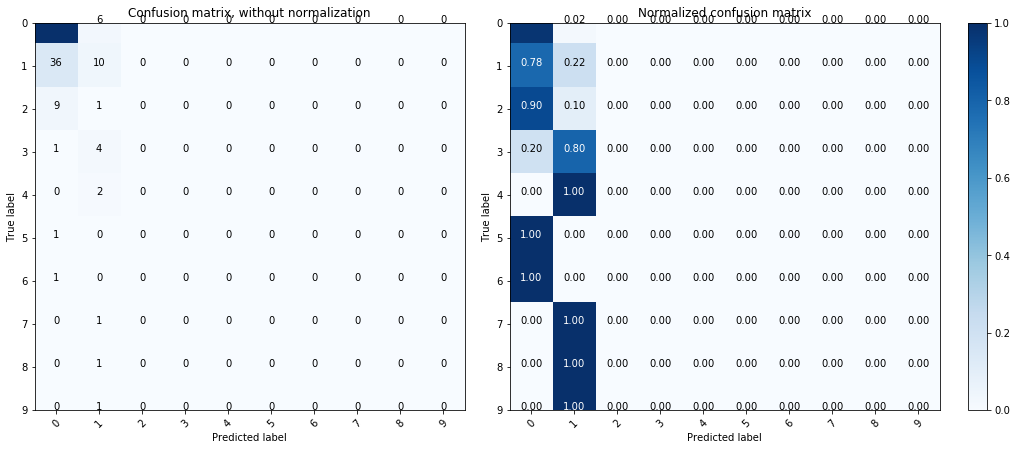

In [16]:
#For classification
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=("0","1","2","3","4","5","6","7","8","9"),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=("0","1","2","3","4","5","6","7","8","9"), normalize=True,
                      title='Normalized confusion matrix')

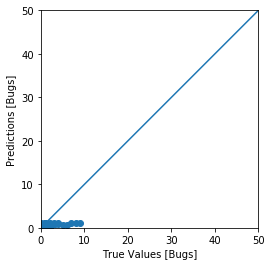

In [74]:
#For regression
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [Bugs]')
plt.ylabel('Predictions [Bugs]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

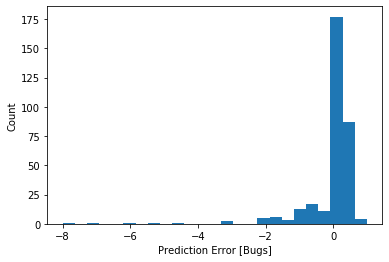

In [75]:
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Bugs]")
_ = plt.ylabel("Count")